# Automatic night input

This script let you set the night in the database automatically. It use the light sensor data to compute it.

If first shows the day/night graph and corresponding date/time and ask for confirmation on the value found

| ![](../images/autonight.jpg) | 
|:--:| 
|Example of graph obtain with autonight. At the beginning of the experiment one can see the high lights while the experiment is starting, then the plateau when lights are on, and the 2nd plateau representing the night, and again on light phase **horizontal red line**:automatic threshold on light value. **pink zone**: dark phases found automatically, **gray zone (surimposed on pink in this example)**: dark phases previously existing in the sequence |

Code launched.
Processing file D:/2019_08_interlab_study_processed_data/20190806_interlab_study_group_01_Experiment 8168.sqlite
--------------
Current file:  D:/2019_08_interlab_study_processed_data/20190806_interlab_study_group_01_Experiment 8168.sqlite
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 3  records loaded in  61.32485103607178 S )
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004417406 Genotype:B6J User1:None
Animal Id:4 Name:D RFID:000004420083 Genotype:B6J User1:None
Animal Id:2 Name:B RFID:000004720521 Genotype:B6N User1:None
Animal Id:3 Name:C RFID:000004721071 Genotype:B6N User1:None
plotting sensor data.  LIGHTVISIBLEANDIR
night  Id( None , None , None , None ) Min/maxFrame: ( None / None ) Loaded ( 3  records loaded in  6.830676078796387 S )
Skipping very short night phase. (less than 10 seconds)
Savi

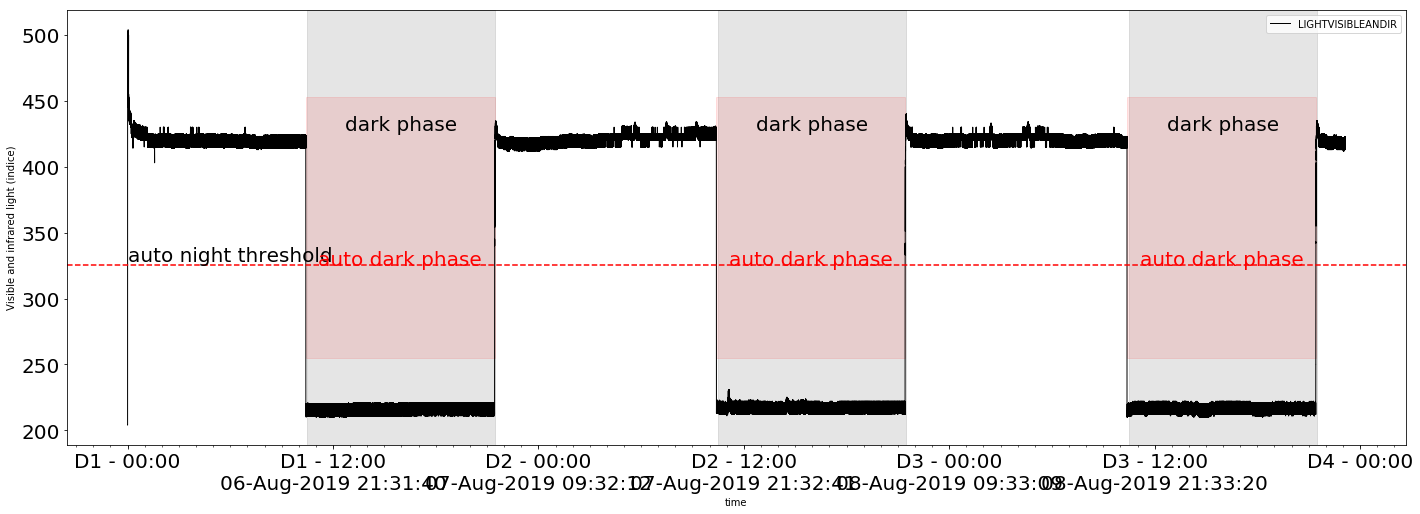

Night # 1
Starts at  06-08 (Aug)-2019 19:56:26
Ends at  07-08 (Aug)-2019 06:58:33
Night # 2
Starts at  07-08 (Aug)-2019 19:56:31
Ends at  08-08 (Aug)-2019 06:58:33
Night # 3
Starts at  08-08 (Aug)-2019 19:56:29
Ends at  09-08 (Aug)-2019 06:58:24
Set night(s) with autoNight data ? [Y/N]:
autoNight canceled.
*** ALL JOBS DONE ***


In [1]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
from lmtanalysis.Event import *
from lmtanalysis.Measure import *
from tkinter.filedialog import askopenfilename
import sys
from lmtanalysis.FileUtil import getFilesToProcess

class FileProcessException(Exception):
    pass

def getDateTime( animalPool, frame ):

    if frame > 0:
        
        datetime = getDatetimeFromFrame( animalPool.conn , frame )
        if datetime != None:
            realTime = getDatetimeFromFrame( animalPool.conn , frame ).strftime('%d-%m (%b)-%Y %H:%M:%S')
            return realTime
    return None


def process( file ):
    
    connection = sqlite3.connect( file )     

    print( "--------------")
    print( "Current file: ", file )
    
    nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )
    nightTimeLine.eventList.clear()
    
    connection = sqlite3.connect( file )
    # build sensor data
    animalPool = AnimalPool( )
    animalPool.loadAnimals( connection )
    autoNightList = animalPool.plotSensorData( 
        sensor = "LIGHTVISIBLEANDIR" , minValue = 40 , saveFile = file+"_log_light visible.pdf", show = True, autoNight = True  )
    
    # show nights 
    
    nightNumber = 1

    if autoNightList == None:
        print("No sensor data found.")
        return
        
    for autoNight in autoNightList:
    
        print( "Night #" , str( nightNumber ) )
        print( "Starts at " , getDateTime( animalPool , autoNight[0] ) )
        print( "Ends at " , getDateTime( animalPool, autoNight[1]) )
        
        nightNumber+=1
    
    # ask confirmation
        
    answer = input ("Set night(s) with autoNight data ? [Y/N]:")
    if answer.lower() == "y":
        print("Setting events...")
        
        nightTimeLine = EventTimeLine( connection, "night" , None, None, None , None )        
        nightTimeLine.eventList.clear()
              
        for autoNight in autoNightList:
            nightTimeLine.addEvent( Event( autoNight[0], autoNight[1] ) )
              
        nightTimeLine.endRebuildEventTimeLine(connection, deleteExistingEvent = True  )
        print("Setting events... Done")
    else:
        print("autoNight canceled.")
    
print("Code launched.")

files = getFilesToProcess()

if ( files != None ):

    for file in files:
        try:
            print ( "Processing file" , file )
            process( file )
        except FileProcessException:
            print ( "STOP PROCESSING FILE " + file , file=sys.stderr  )

print( "*** ALL JOBS DONE ***")